- Intructions on this Repo
1. Heap size error run this command line before run jupyter notebook on command line

export PYSPARK_SUBMIT_ARGS=' --conf spark.sql.shuffle.partitions=700 --conf spark.default.parallelism=700 --driver-memory 30g --driver-cores 6 --executor-memory 30g --executor-cores 6 pyspark-shell'

OR you can configurate SparkConf and create Spark Context class with it

2. ERROR PythonRunner: Python worker exited unexpectedly (crashed) java.net.SocketException: Connection reset

Try to run several times

## Demand Forecasting

The objective of this notebook is to illuate how we might leverage the Apache Spark - the efficient distribution of the work required to generate hundreds of thousands or even millions of ML models in a timely manner and FBProphet - popular library for demanding forecasting.

NOTE: The original notebook utilized the DataBricks and DataLakes. In this notebook, I will use my Spark SQL and localhost storage to emulate the orginal notebook 

### Exploring Data
- Source: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

A relatively simple and clean dataset, given 5 years of store-item sales data(10 stores), and asked to predict 3 months of sales for 50 different items at 10 different stores. 

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? 



#### Import Data from local to sql database
- use pyspark to import data to sql database, to work similarly to DataBricks notebook

In [203]:
#expand current working jupyter notebook to full browser view
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#libraries
import pandas as pd
import numpy as np

#### Create SQL databse using Pyspark


In [3]:
#libraries
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
print(f"Pyspark Version: {pyspark.__version__}")

Pyspark Version: 3.2.3


In [4]:
#Create a spark Context class, with custom config
conf = SparkConf()
#conf.set('spark.sql.debug.maxToStringFields', 100)
conf.set('spark.default.parallelism', 700)
conf.set('spark.sql.shuffle.partitions', 700)
conf.set('spark.driver.memory', '30g')
conf.set('spark.driver.cores', 8)
conf.set('spark.executor.cores', 8)
conf.set('spark.executor.memory', '30g')
conf.set("spark.jars.packages", "io.delta:delta-core_2.12:2.0.0")
conf.set('spark.sql.extensions', 'io.delta.sql.DeltaSparkSessionExtension')
conf.set('spark.sql.catalog.spark_catalog', 'org.apache.spark.sql.delta.catalog.DeltaCatalog')

sc = SparkContext.getOrCreate(conf)

:: loading settings :: url = jar:file:/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hople/.ivy2/cache
The jars for the packages stored in: /Users/hople/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b00620d5-5c31-41b8-bb58-cc4dd1cb79ea;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.0.0 in central
	found io.delta#delta-storage;2.0.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 455ms :: artifacts dl 31ms
	:: modules in use:
	io.delta#delta-core_2.12;2.0.0 from central in [default]
	io.delta#delta-storage;2.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|ev

In [5]:
#import library
from delta import *
#we need to config sparksession with delta lake for later use in this repo
my_packages = ["io.delta:delta-core_2.12:2.0.0"]
builder = (pyspark.sql.SparkSession.builder.appName("Time Serries Forecasting")\
           .config('spark.master','local[*]'))

spark = configure_spark_with_delta_pip(builder, extra_packages=my_packages).getOrCreate()

In [6]:
#read the training data into a dataframe, and convert to datatype accordingly
#library
from pyspark.sql.types import *

#structure of the training dataset
train_schema = StructType([
    StructField('date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('sales', IntegerType())
])

spdf_data = spark.read.csv('./Data/train.csv', header=True, schema=train_schema)

In [7]:
spdf_data.printSchema()

root
 |-- date: date (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)



In [8]:
#make the temporary view table
spdf_data.createOrReplaceTempView('train')

In [9]:
##load sparksql magic to run sql queries in notebook cell
%load_ext sparksql_magic

In [10]:
%%sparksql
SELECT * FROM train;

only showing top 20 row(s)


date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


##### General annual trends and seasonality in unit sales
NOTE: DataBricks sql is able to visuallize immediately with sql queries in notebook cells, on Jupyter notebook we will create dataframe and visuallize using python visuallize libraries

##### Plot the annual trending 

In [11]:
%%sparksql
SELECT year(date) as year,
        sum(sales) as sales 
    FROM train 
    GROUP BY year(date) 
    ORDER BY year;

year,sales
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740


In [12]:
#collect data
query_annual_trending ='\
    SELECT year(date) as year,\
            sum(sales) as sales \
    FROM train \
    GROUP BY year(date) \
    ORDER BY year;'
collected_annual_trending = spark.sql(query_annual_trending).collect()

In [13]:
collected_annual_trending

[Row(year=2013, sales=7941243),
 Row(year=2014, sales=9135482),
 Row(year=2015, sales=9536887),
 Row(year=2016, sales=10357160),
 Row(year=2017, sales=10733740)]

In [14]:
#convert to dataframe for plotting
df_annual_trending = pd.DataFrame(collected_annual_trending, columns=['year', 'million_sales'])
df_annual_trending['million_sales'] = df_annual_trending['million_sales'].apply(lambda x: x/10**6)

In [15]:
df_annual_trending

,year,million_sales
0,2013,7.941243
1,2014,9.135482
2,2015,9.536887
3,2016,10.357160
4,2017,10.733740


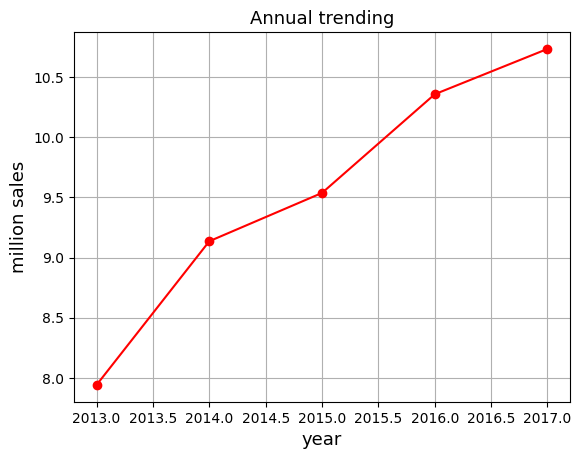

In [16]:
#plot
import matplotlib.pyplot as plt

plt.plot(df_annual_trending['year'], df_annual_trending['million_sales'], color='red', marker='o')
plt.title("Annual trending", fontsize=13)
plt.xlabel('year', fontsize=13)
plt.ylabel('million sales', fontsize=13)
plt.grid(True)
plt.show()

It is very clear growth from our annual trending chart in total sales across the stores. From this trend, we are able to expect our warehouse capacity to increase, and We might expect continued growth in few days, months.

##### Plotting Seasonality trend

In [17]:
%%sparksql
SELECT
    TRUNC(date, 'MM') as month,
    SUM(sales) as sales
FROM train
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

only showing top 20 row(s)


month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


In [18]:
#collect data
query_seasonality_trending ="\
    SELECT TRUNC(date, 'MM') as month,\
            sum(sales) as sales \
    FROM train \
    GROUP BY TRUNC(date, 'MM') \
    ORDER BY month;"
collected_seasonality_trending = spark.sql(query_seasonality_trending).collect()

In [19]:
collected_seasonality_trending[0:10]

[Row(month=datetime.date(2013, 1, 1), sales=454904),
 Row(month=datetime.date(2013, 2, 1), sales=459417),
 Row(month=datetime.date(2013, 3, 1), sales=617382),
 Row(month=datetime.date(2013, 4, 1), sales=682274),
 Row(month=datetime.date(2013, 5, 1), sales=763242),
 Row(month=datetime.date(2013, 6, 1), sales=795597),
 Row(month=datetime.date(2013, 7, 1), sales=855922),
 Row(month=datetime.date(2013, 8, 1), sales=766761),
 Row(month=datetime.date(2013, 9, 1), sales=689907),
 Row(month=datetime.date(2013, 10, 1), sales=656587)]

In [20]:
#convert to dataframe for plotting
df_seasonality_trending = pd.DataFrame(collected_seasonality_trending, columns=['month', 'thousand_sales'])
df_seasonality_trending['thousand_sales'] = df_seasonality_trending['thousand_sales'].apply(lambda x: x/1000)

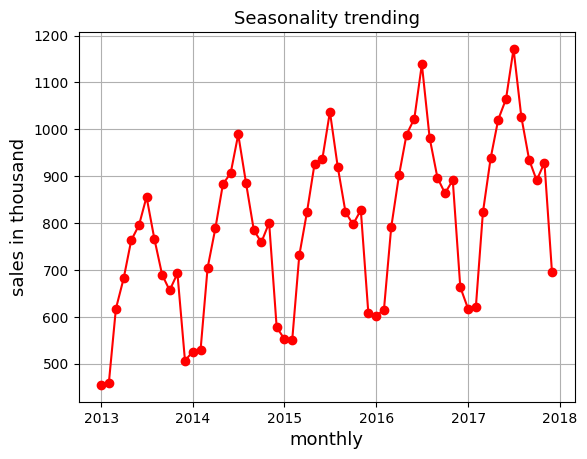

In [147]:
#simple plot
import matplotlib.pyplot as plt
%matplotlib inline
##
plt.plot(df_seasonality_trending['month'], df_seasonality_trending['thousand_sales'], color='red', marker='o')
plt.title('Seasonality trending', fontsize=13)
plt.xlabel('monthly', fontsize=13)
plt.ylabel('sales in thousand', fontsize=13)
plt.grid(True)

plt.show()

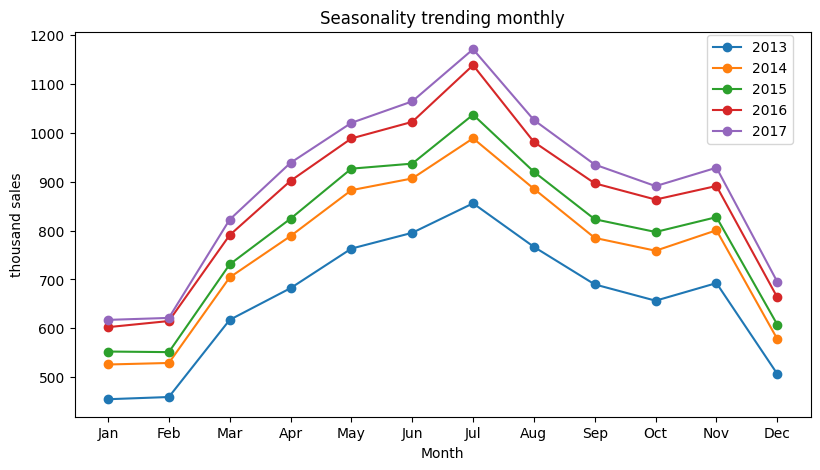

In [148]:
#seasonality trending in each year
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_seasonality_trending.copy() #stop cause error when editing on same df
df_plotting['month'] = pd.to_datetime(df_plotting['month'])
df_plotting.set_index('month', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index.month,
                    columns=df_plotting.index.year)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure(figsize=(9.5,5)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("Month")
ax.set_ylabel('thousand sales')

ticklabels = [datetime.date(2023, item, 1).strftime('%b') for item in pt_df_plotting.index] #get month label in string format
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis
ax.set_title('Seasonality trending monthly')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.85, .85)) #add the column names as legend.

plt.show()

We sees that monthly parttern is increasing from Feb, peak on Jun and start to going down on Dec. This pattern is stable from year 2013 to year 2017

##### Plotting the weakly seasonality trending

0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday

In [27]:
%%sparksql
SELECT YEAR(date) as year, WEEKDAY(date) as weekday, AVG(sales) as avg_sales
FROM (SELECT date, SUM(sales) as sales
      FROM train
      GROUP BY date
      ORDER BY date)
GROUP BY year, weekday
ORDER BY year, weekday;

only showing top 20 row(s)


year,weekday,avg_sales
2013,0,17269.69230769231
2013,1,20015.811320754718
2013,2,20150.153846153848
2013,3,21503.19230769231
2013,4,23071.096153846152
2013,5,24532.903846153848
2013,6,25788.44230769231
2014,0,19791.98076923077
2014,1,23179.346153846152
2014,2,23009.471698113208


In [151]:
#collect data to convert to dataframe
query_weekday_seasonality_trending ='''\
SELECT YEAR(date) as year, WEEKDAY(date) as weekday, AVG(sales) as avg_sales \
FROM (SELECT date, SUM(sales) as sales \
        FROM train \
        GROUP BY date) \
GROUP BY year, weekday \
ORDER BY year, weekday;'''

#collected_weekday_seasonality_trending = spark.sql(query_weekday_seasonality_trending).toPandas()

#map weekday
map_weekday = {0: "Monday", 1: "Tuesday", 2: "Wednesday",
               3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
#convert to dataframe for plotting
df_weekday_seasonality_trending = spark.sql(query_weekday_seasonality_trending).toPandas()
df_weekday_seasonality_trending['weekday'] = df_weekday_seasonality_trending['weekday'].map(map_weekday)

In [152]:
df_weekday_seasonality_trending.head(5)

,year,weekday,avg_sales
0,2013,Monday,17269.692308
1,2013,Tuesday,20015.811321
2,2013,Wednesday,20150.153846
3,2013,Thursday,21503.192308
4,2013,Friday,23071.096154


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

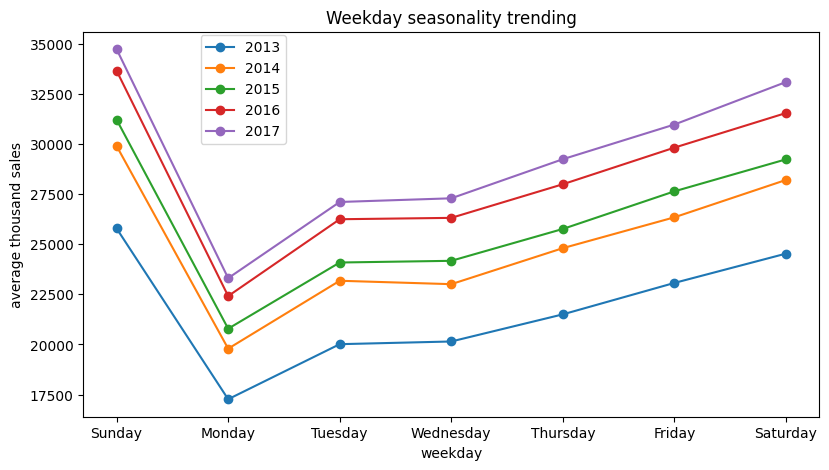

In [153]:
#weekday seasonality trending in each year
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_weekday_seasonality_trending.copy() #stop cause error when editing on same df
#df_plotting['month'] = pd.to_datetime(df_plotting['month'])
df_plotting.set_index('weekday', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index,
                    columns=df_plotting.year, sort=False)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

#sorting Indext to start with sunday and end in Saturday
pt_df_plotting = pd.concat([pt_df_plotting.loc[['Sunday']], pt_df_plotting.loc['Monday': 'Saturday']], axis=0)

ax = plt.figure(figsize=(9.5,5)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("weekday")
ax.set_ylabel('average thousand sales')

ax.set_title('Weekday seasonality trending')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.15, .85)) #add the column names as legend.

plt.show()

In [154]:
pt_df_plotting

year,2013,2014,2015,2016,2017
weekday,,,,,
Sunday,25788.442308,29901.000000,31213.903846,33654.519231,34730.113208
Monday,17269.692308,19791.980769,20787.903846,22415.519231,23309.000000
Tuesday,20015.811321,23179.346154,24089.961538,26248.730769,27109.711538
Wednesday,20150.153846,23009.471698,24174.346154,26317.096154,27292.788462
Thursday,21503.192308,24805.884615,25763.679245,27994.038462,29243.134615
Friday,23071.096154,26344.750000,27640.826923,29820.339623,30973.000000
Saturday,24532.903846,28207.423077,29235.596154,31545.792453,33092.442308


The basic weekday pattern with our data is an increasing consumption start on Monday, peak at Sunday and dropping at Monday again. We can predict on this trending for weekday consumption

### Build a Forecast
We will start to build a single forecast with FBProphet

In [155]:
%%sparksql
SELECT CAST(date as date) as ds, store, item, sales as y
FROM train
WHERE store=1 AND item=1
ORDER BY ds;

only showing top 20 row(s)


ds,store,item,y
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12
2013-01-10,1,1,9


In [156]:
#query to collect data
query_1store_forecast = """
SELECT CAST(date as date) as ds, sales as y
FROM train
WHERE store=1 AND item=1
ORDER BY ds;
"""
#assemble dataset in pandas df
df_1store_forecast = spark.sql(query_1store_forecast).toPandas()

#drop any missing records
df_1store_forecast = df_1store_forecast.dropna()

In [157]:
df_1store_forecast.head(5)

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [158]:
df_1store_forecast.describe()

,y
count,1826.000000
mean,19.971522
std,6.741022
min,4.000000
25%,15.000000
50%,19.000000
75%,24.000000
max,50.000000


We now will import fbprophet library, and tune the logging setting

In [159]:
from fbprophet import Prophet
import logging

#disable information messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

We will set overall growth param to linear base on trending EDA above and enable the evaluation of weekly and uearly seasonal patterns. We might also wish to set our seasonality mode to multiplicative as the seasonal pattern seems to grow with overall growth is sales

In [193]:
#stop warnings, because fbprophet have not update merging method working with dataframe
import warnings
warnings.filterwarnings('ignore')

In [194]:
#set model params
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
#fit the model to historical data
model.fit(df_1store_forecast)

Initial log joint probability = -18.4541


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       3520.62   0.000177102       75.5416   2.713e-06       0.001      169  LS failed, Hessian reset 
      99       3520.64   8.62856e-05       50.4909      0.9699      0.9699      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       3520.68   5.06209e-05       54.5957   8.201e-07       0.001      346  LS failed, Hessian reset 
     199       3520.68   3.78129e-06       38.3929      0.3618           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3520.68    6.8478e-06       73.2674   9.599e-08       0.001      455  LS failed, Hessian reset 
     260       3520.68   1.22061e-07       44.9099     0.07806      0.2692      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


We completed the trained model, lets use it for 90-day forrecast on first single store

In [195]:
#we define dataset, include historical dates with 90 day forecast
datedt_hist_fure = model.make_future_dataframe(
            periods=90,
            freq='d',
            include_history=True
)
df_forecast_hist_fure = model.predict(datedt_hist_fure)

In [41]:
datedt_hist_fure.head(5)

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [42]:
df_forecast_hist_fure.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,15.601853,1.365064,18.577190,15.601853,15.601853,-0.356005,-0.356005,-0.356005,-0.088832,-0.088832,-0.088832,-0.267173,-0.267173,-0.267173,0.0,0.0,0.0,10.047511
1,2013-01-02,15.607552,2.083713,18.827997,15.607552,15.607552,-0.325667,-0.325667,-0.325667,-0.059022,-0.059022,-0.059022,-0.266645,-0.266645,-0.266645,0.0,0.0,0.0,10.524681
2,2013-01-03,15.613250,2.793564,18.645998,15.613250,15.613250,-0.292319,-0.292319,-0.292319,-0.025389,-0.025389,-0.025389,-0.266929,-0.266929,-0.266929,0.0,0.0,0.0,11.049203
3,2013-01-04,15.618948,3.412090,20.229675,15.618948,15.618948,-0.216325,-0.216325,-0.216325,0.051662,0.051662,0.051662,-0.267986,-0.267986,-0.267986,0.0,0.0,0.0,12.240186
4,2013-01-05,15.624646,5.256290,22.691575,15.624646,15.624646,-0.118330,-0.118330,-0.118330,0.151423,0.151423,0.151423,-0.269752,-0.269752,-0.269752,0.0,0.0,0.0,13.775785


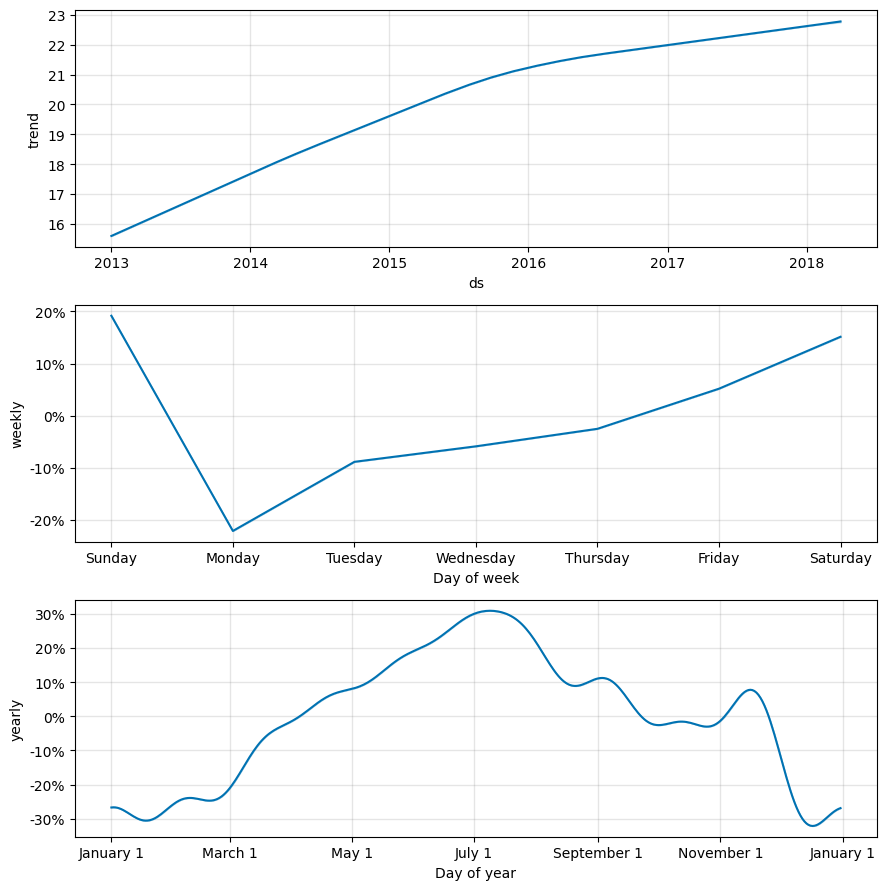

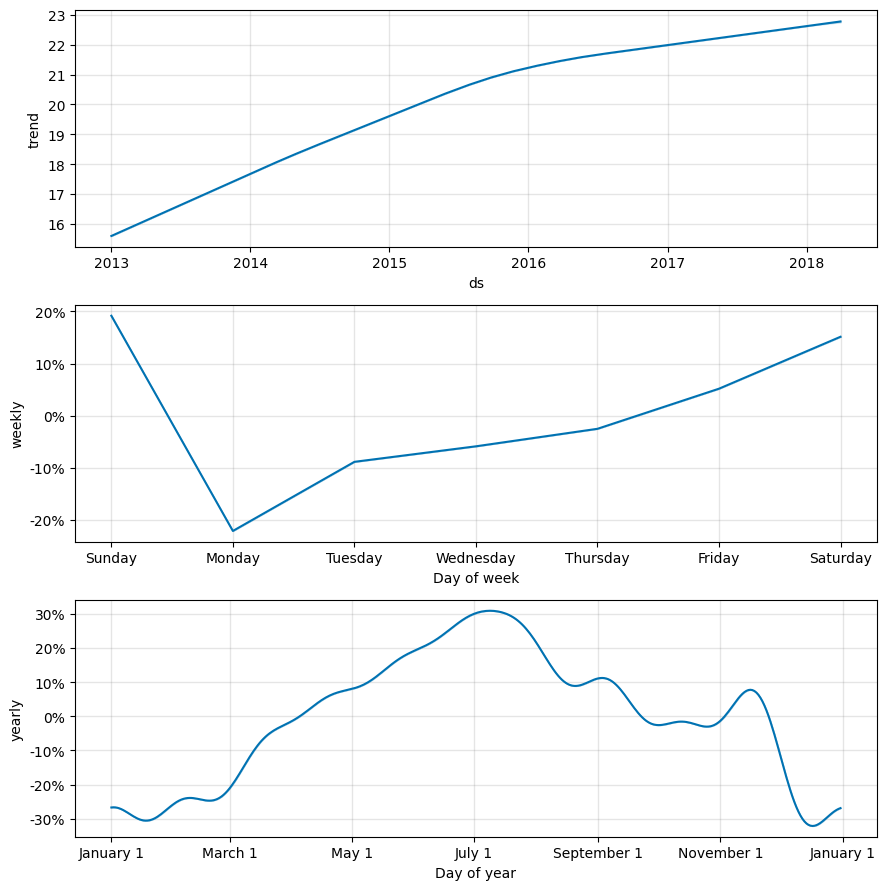

In [196]:
trends_fig = model.plot_components(df_forecast_hist_fure)
display(trends_fig)

#### Evaluate our model using Visualize function with model

We now will see how our actual and predicted data line ip as well as a forecast

<IPython.core.display.Javascript object>


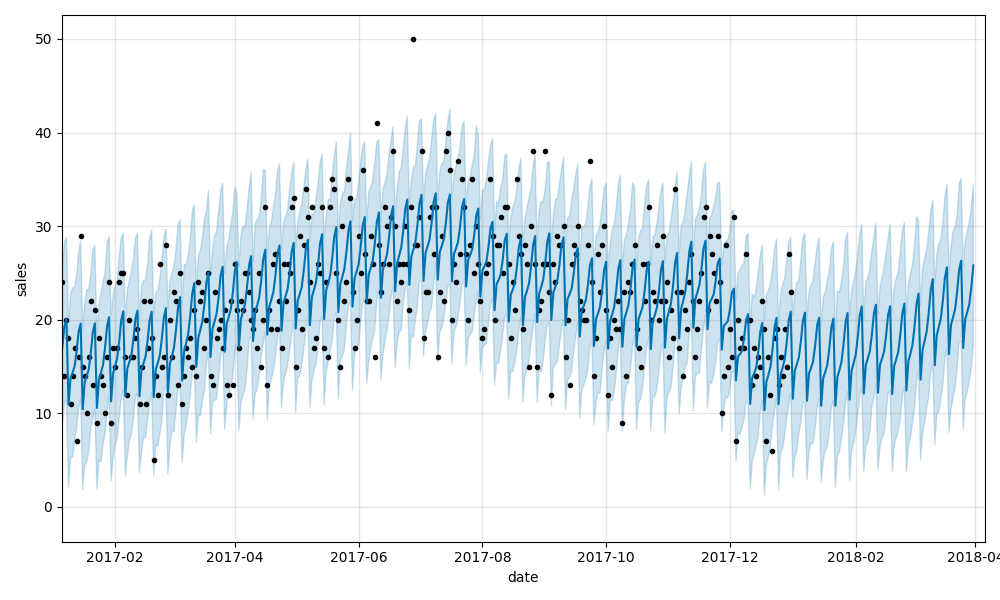

(17171.75, 17626.75)

In [44]:
predict_fig = model.plot(df_forecast_hist_fure, xlabel='date', ylabel='sales')

#adjust figure to display dates from last year and the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

The black dot represents our actual data, and the blue line represents our predicted data, the light blue band represents our (95%) uncertainty interval.

#### Evaluate model with MAE, MSE, RMSE

In [45]:
pd.to_datetime("2018-1-1")

Timestamp('2018-01-01 00:00:00')

In [197]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from datetime import date

#get historical actuals & predictions for comparison pandas.to_datetime(data['date'])
df_actuals_data = df_1store_forecast[df_1store_forecast['ds'] < pd.Timestamp(2018, 1, 1)]['y']
df_predicted_data = df_forecast_hist_fure[df_forecast_hist_fure['ds'] < pd.Timestamp(2018, 1, 1)]['yhat']

#calculate evaluation metrics
mae = mean_absolute_error(df_actuals_data, df_predicted_data)
mse = mean_squared_error(df_actuals_data, df_predicted_data)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse))

MAE: 3.486559544351376
MSE: 19.388724195449495
RMSE: 4.403262903285414


#### Evaluate using Cross Validation

selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [198]:
#import cross validation from Fprophet with argument below
from fbprophet.diagnostics import cross_validation
#initial = size of train dataset, with 3 years training data over our 5 year dataset
#horizon = size to be forecasted, 90 days forecast
#period = spacing between cutoff dates as incremental, ussually halft of horizon, every 45 days
df_cv_1store = cross_validation(model, initial='1065 days', period='90 days', horizon='90 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2016-01-11 00:00:00 and 2017-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

Initial log joint probability = -38.9843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2008.98    0.00244692       225.475   2.488e-05       0.001      139  LS failed, Hessian reset 
      99       2009.37    0.00075262       103.278           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2009.75    0.00093734       118.134    8.53e-06       0.001      252  LS failed, Hessian reset 
     199       2009.88   3.76455e-08       73.0542      0.4279      0.4279      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       2009.88   9.64422e-08       75.5755      0.2502      0.9723      330   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -34.5697
    Iter      log prob        ||dx||      ||grad||   

In [48]:
df_cv_1store

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-01-12,13.311458,5.268223,22.041287,13,2016-01-11
1,2016-01-13,14.059992,6.169159,22.513329,9,2016-01-11
2,2016-01-14,14.596205,6.455671,22.488476,18,2016-01-11
3,2016-01-15,16.644040,8.427565,24.650439,13,2016-01-11
4,2016-01-16,18.693441,10.267114,26.249447,8,2016-01-11
...,...,...,...,...,...,...
715,2017-12-27,15.126029,6.735306,24.145442,14,2017-10-02
716,2017-12-28,15.866180,7.567127,24.790818,19,2017-10-02
717,2017-12-29,17.928795,9.202262,26.507169,15,2017-10-02
718,2017-12-30,20.006505,10.351808,28.572131,27,2017-10-02


In [49]:
#The performance_metrics utility can be used to compute some useful statistics of the prediction performance
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv_1store)

In [50]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,23.776680,4.876134,3.950937,0.240754,0.182064,0.902778
1,10 days,25.421274,5.041951,4.140523,0.249355,0.190529,0.888889
2,11 days,24.271269,4.926588,4.014951,0.235866,0.182064,0.902778
3,12 days,25.254048,5.025341,4.134820,0.241933,0.182064,0.902778
4,13 days,25.046085,5.004606,4.090799,0.238181,0.176959,0.888889
...,...,...,...,...,...,...,...
77,86 days,30.344874,5.508618,3.994245,0.220303,0.133149,0.888889
78,87 days,31.509442,5.613327,4.134688,0.215644,0.142674,0.888889
79,88 days,31.647479,5.625609,4.225199,0.218916,0.154451,0.888889
80,89 days,31.151110,5.581318,4.173489,0.211319,0.149953,0.902778


<IPython.core.display.Javascript object>


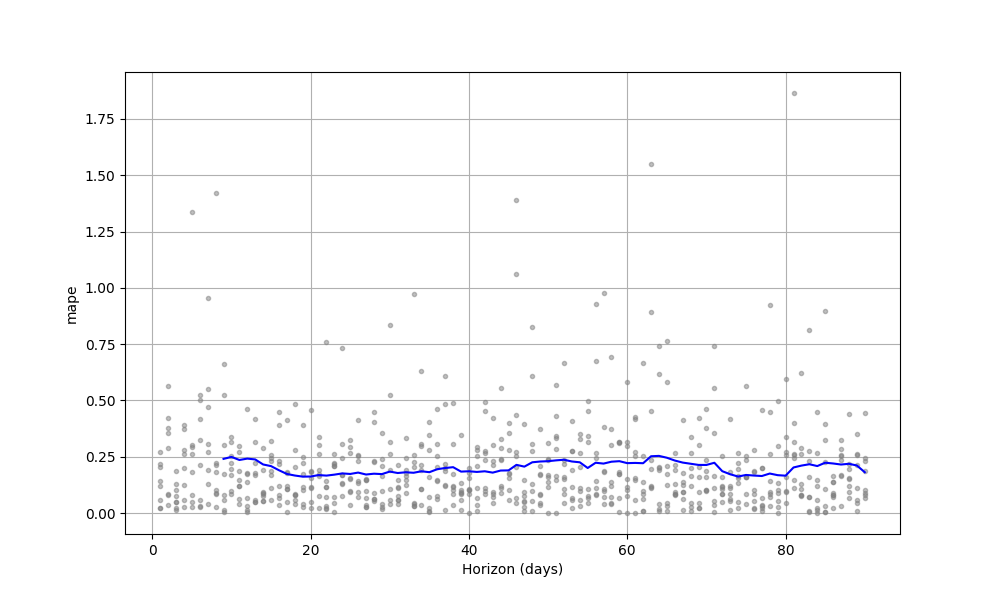

In [51]:
##visualized with plot_cross_validation_metric
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv_1store, metric='mape')

### Scaling Model Training & Forecasting
Now we going to build numberous, fine-grain models and forecast for indivual store and item combinations

In [52]:
##sql to collect data from database
sql_all_store_items = """
                    SELECT store, item, DATE(date) as ds, SUM(sales) as y
                    FROM train
                    GROUP BY store, item, ds
                    ORDER BY store, item, ds
                    """

spsql_store_item_history = (
    spark.sql(sql_all_store_items).repartition(sc.defaultParallelism, ['store', 'item'])).cache()

In [53]:
spsql_store_item_history.show(5)

+-----+----+----------+---+
|store|item|        ds|  y|
+-----+----+----------+---+
|    7|  16|2013-01-01| 11|
|    7|  16|2013-01-02| 10|
|    7|  16|2013-01-03|  9|
|    7|  16|2013-01-04|  8|
|    7|  16|2013-01-05| 11|
+-----+----+----------+---+
only showing top 5 rows



Our goal is to build a model for each store and item combination, so we will need to pass in a store-item subset from the dataset we assembled, train a model on that subset, and receive a store-item forecast back. We'd expect that forecast to be returned as a datset with a structure like this where we retrain the store and item identifiers for which the forecast was assembled and we limit the output ot just the relevant subset of fields generated by the Prophet model:

In [54]:
from pyspark.sql.types import *

#create schema for the forecast output returned
result_schema = StructType([
    StructField('ds', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('y', FloatType()),
    StructField('yhat', FloatType()),
    StructField('yhat_upper', FloatType()),
    StructField('yhat_lower', FloatType())
])

Using Pandas user-defined function (UDF) to train the model and generate a forecast. We will define this function to receive a subset of data organized around a store and item combination. It will return a forecast in the format identified in the schema structure we created above

In [83]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_store_item(history_pd):
    #TRAIN MODEL
    # -------------------------
    #remove missing values
    history_pd = history_pd.dropna()
    
    # configure the model
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )
    
    #train the model
    model.fit(history_pd)
    #--------------------
    
    #BUILD FORECAST
    #--------------------
    #make predictions
    furture_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )
    
    forecast_pd = model.predict(furture_pd)
    #--------------------
    
    #ASSEMBLE EXPECTED RESULT SET
    #--------------------
    # get relevant fields from forecast
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    
    #get relevant fields from history
    h_pd = history_pd[['ds', 'store', 'item', 'y']].set_index('ds')
    
    #Join history and forecast
    results_pd = f_pd.join(h_pd, how='left')
    results_pd.reset_index(level=0, inplace=True)
    
    #get store & item from incoming data set
    results_pd['store'] = history_pd['store'].iloc[0]
    results_pd['item'] = history_pd['item'].iloc[0]
    #-------------------
    
    #return expected dataset
    return results_pd[['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

call our UDF to build our forecasts. we do this by grouping our historical dataset around store and item. We then apply our UDF to each group and tack on today's date as our training_date for data management purposes

In [84]:
spsql_store_item_history.show(5)

+-----+----+----------+---+
|store|item|        ds|  y|
+-----+----+----------+---+
|    7|  16|2013-01-01| 11|
|    7|  16|2013-01-02| 10|
|    7|  16|2013-01-03|  9|
|    7|  16|2013-01-04|  8|
|    7|  16|2013-01-05| 11|
+-----+----+----------+---+
only showing top 5 rows



In [199]:
from pyspark.sql.functions import current_date

#Group data on store and item level, then use function forecast to forecast on thi store and item level
results = (
    spsql_store_item_history.groupBy('store',
        'item').apply(forecast_store_item).withColumn('training_date', current_date())
)

results.createOrReplaceTempView('new_forecasts')

In [200]:
results.show()

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -18.9957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       3401.89   4.78891e-05        52.019   8.059e-07       0.001      129  LS failed, Hessian reset 
      84       3401.89   7.31079e-06       55.5759    1.48e-07       0.001      199  LS failed, Hessian reset 
      94       3401.89   3.34275e-07       44.0209      0.2725           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

+----------+-----+----+----+----------+----------+-----------+-------------+
|        ds|store|item|   y|      yhat|yhat_upper| yhat_lower|training_date|
+----------+-----+----+----+----------+----------+-----------+-------------+
|2013-01-01|    7|  16|11.0|   8.99916| 17.088747| 0.36908153|   2023-02-27|
|2013-01-02|    7|  16|10.0|  8.448533| 16.563885|-0.08734294|   2023-02-27|
|2013-01-03|    7|  16| 9.0|  9.458642| 17.124395| 0.93580717|   2023-02-27|
|2013-01-04|    7|  16| 8.0|  9.978263| 17.928818|  1.5824509|   2023-02-27|
|2013-01-05|    7|  16|11.0| 11.434878|  20.42601|   2.802342|   2023-02-27|
|2013-01-06|    7|  16| 8.0| 12.744255| 20.832737|  4.9358015|   2023-02-27|
|2013-01-07|    7|  16| 7.0| 6.5255313| 14.636395| -0.9983418|   2023-02-27|
|2013-01-08|    7|  16| 8.0|  8.550012| 16.973408| 0.17010672|   2023-02-27|
|2013-01-09|    7|  16| 8.0|   8.02272| 15.942222|-0.13675426|   2023-02-27|
|2013-01-10|    7|  16| 8.0|  9.074206| 16.930927|  1.1657163|   2023-02-27|

save our results to a queriable table structure

In [91]:
%%sparksql
-- create forecast table
CREATE TABLE IF NOT EXISTS forecasts (
    date date,
    store integer,
    item integer,
    sales float,
    sales_predicted float,
    sales_predicted_upper float,
    sales_predicted_lower float,
    training_date date
)
USING delta
PARTITIONED BY (training_date);

In [92]:
%%sparksql
-- load data into table
INSERT INTO forecasts
SELECT ds as date,
    store,
    item,
    y as sales,
    yhat as sales_predicted,
    yhat_upper as sales_predicted_upper,
    yhat_lower as sales_predicted_lower,
    training_date
FROM new_forecasts;

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -33.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -23.2019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       3989.58   0.000205579        128.58   1.902e-06       0.001      174  LS failed, Hessian reset 
      99       3989.63   0.000200338       64.8608       0.986       0.986      180   
    It

      99       3406.38   6.90897e-07       86.6325      0.2715           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       3406.38   1.17324e-07       82.4576      0.3012           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       4049.96   4.78879e-05        71.732           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

      99       3339.63     1.041e-06       58.5015      0.1875      0.4703      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4276.2   0.000721008        100.67           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3973.98   0.000319101       83.7649           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3837.94   0.000214341       86.2523       0.263       0.263      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3797.7   0.000170108       94.2397           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3381.91   0.000370693       135.396   3.183e-06       0.001      166  LS failed, Hessian r

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

     246       3295.41   1.18283e-07       71.0519      0.1523           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     193    

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     145       3386.98   5.86084e-06       81.6203   7.322e-08       0.001      255  LS failed, Hessian reset 
      99       3642.56   1.52702e-05       53.2395           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       3386.98   1.79776e-07       62.3877      0.5736      0.5736      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

     195       3885.96   3.26157e-07       87.5195           1           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/minicon

      99        3161.8   6.05466e-06       85.0963           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        3161.8   2.19445e-07       74.1089           1           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWar

     158       3793.97   1.89322e-07       78.5916      0.3789           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     173       4059.57   9.11537e-08       68.1296      0.4004      0.4004      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     167       4161.84   1.88583e-07       65.0274      0.3242           1      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be re

      68       3921.38   0.000125155       85.5686   1.094e-06       0.001      126  LS failed, Hessian reset 
      99       4138.21   3.60068e-05        106.83      0.1385      0.1385      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4215.57   7.00522e-05       79.3312           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3921.41   9.25124e-07       50.9511      0.3259      0.3259      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       4138.32   0.000365139       130.759   4.104e-06       0.001      208  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = comp

      99       4266.63   0.000692609       82.7843      0.1169           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3417.71   5.71608e-07       60.3108      0.6727      0.6727      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        4266.8   2.78606e-08       79.1127      0.0623           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     220       3417.71   6.15263e-06       59.4196   7.207e-08       0.001      400  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/for

     225       4045.53   3.77941e-08       62.2502      0.1338      0.1338      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     229       3606.78   1.12168e-07       87.9823      0.2632      0.7234      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -41.6087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -30.297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

     199       4265.01   0.000494879       82.6088           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       4265.09   0.000193094       99.5627   2.737e-06       0.001      335  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -29.3958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260        4265.2   8.24798e-05       85.1592   9.483e-07       0.001      445  LS failed, Hessian reset 
     299       4265.21    0.00028808       75.6369      0.1561           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       4265.22

      99       4331.29   0.000246293       101.531           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       4331.41   8.90218e-05       87.9162   7.922e-07       0.001      198  LS failed, Hessian reset 
      99       3167.43     0.0020569       71.2002           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -51.5255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4331.46   3.13264e-05       76.7956           1           1      301   
    Iter      log prob        ||dx||      ||gr

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -27.7397
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4217.1   0.000232144       64.0988           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4020.47   2.61213e-05       58.2578      0.1983           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       4217.31    6.1156e-08        81.203     0.06375     0.06375      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-

     151       3478.87   4.18879e-05       88.4578   4.919e-07       0.001      276  LS failed, Hessian reset 
     175       3478.87   4.26452e-08       71.3973      0.2786      0.2786      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

     183       3572.85   2.64734e-05       79.8978   3.623e-07       0.001      356  LS failed, Hessian reset 
     199       3572.85   1.27166e-06       58.5877           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       3894.48   4.11937e-07       63.1693      0.3489           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     211       3572.85   9.05139e-08       80.6193      0.4049      0.4049      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages

     213       4138.94   3.70898e-07       79.8786           1           1      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/minicon

Initial log joint probability = -25.9389                         (80 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -19.7306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3923.47   7.31029e-07        71.168           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3923.47    1.6371e-07       74.8536      0.1301      0.3526      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packag

     199       3971.57   2.56894e-05       48.5584      0.5587           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     239       3971.57   5.21227e-06       80.5608   7.469e-08       0.001      400  LS failed, Hessian reset 
Initial log joint probability = -35.6045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       3971.57   2.70917e-07       51.9339      0.6103           1      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

     127       3903.79   1.60038e-07       65.1238      0.4119           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99        3869.9   0.000194389       72.4109           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      92       3961.47   0.000203482       125.292   2.272e-06       0.001      155  LS failed, He

     199       3957.15   9.16163e-06       91.4891           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4177.52     0.0001237        74.767           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        3957.2   7.12018e-05       74.6595   1.101e-06       0.001      342  LS failed, Hessian reset 
     240       4177.56   0.000192583       131.177   1.722e-06       0.001      371  LS failed, Hessian reset 
     250       3957.21   1.28205e-07       67.4892      0.3526           1      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

     145       3767.52   6.69366e-06       87.9996   7.509e-08       0.001      219  LS failed, Hessian reset 
     159       3767.52   1.01652e-07       80.0852      0.4975      0.4975      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     139       4343.43   0.000272399       125.395   3.753e-06       0.001      205  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     231       3815.67   1.71263e-05       77.0201   2.178e-07       0.001      431  LS failed, Hessian reset 
     299       4337.75   4.21153e-05       90.3978       4.518      0.4518      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthous

Initial log joint probability = -27.2115                        (100 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -56.922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3313.81    0.00426348       173.916           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3824.56    0.00915106       90.5929      0.4237           1      126   
      94       3505.68   3.10456e-07       79.6559           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       3500.19   0.000388403       107.173           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -29.9541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     119       3500.27   0.000151882       69.5205   1.687e-06       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -18.1292
    It

     227       3936.33   5.01386e-05       73.8187   5.767e-07       0.001      455  LS failed, Hessian reset 
      99       4317.17   0.000354611       59.9113           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       3936.34   2.17447e-07       81.4982      0.3819      0.3819      522   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

     286       4079.39   1.67435e-07       80.8769      0.3881      0.3881      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3846.73     1.671e-06       53.5521   3.301e-08       0.001      374  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4015.26   0.000195001       90.4821       0.312           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3846.73    1.9451e-07       68.4575      0.2861      0.2861      385   
Optimization terminated normally: 
  Convergence detected: relative gradi

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -47.3373
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4291.5    1.0295e-05       80.6915           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        4291.5   2.86687e-07       58.7548      0.2412      0.2412      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3718.57   1.04483e-05       77.2165           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     485       3508.66   1.72302e-07       72.4261      0.3434           1      745   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     237       3718.58   1.31089e-05       88.3159   1.582e-07       0.001      376  LS failed, He

Initial log joint probability = -18.4541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4152.54   1.02785e-06       79.5979           1           1      311   
     167       4129.91   2.66958e-05       74.6121   3.943e-07       0.001      304  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       4152.54   4.49352e-07       63.7941       1.786      0.3784      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     191       3966.53   0.000510706       101.845   5.963e-06       0.001      310  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.1908
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88        3530.5   0.000337573       104.279   3.595e-06       0.001      142  LS failed, Hessian reset 
      99       3530.52   1.66029e-05       79.4079      0.2521           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -43.329
    Ite

     248       4242.48   1.56581e-07       71.6661      0.5323      0.5323      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       4295.42   4.52242e-06        62.077      0.6331      0.6331      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       4295.42   1.05575e-06       68.5309      0.2628      0.9418      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pan

     242       4162.18   1.15609e-05       103.253    1.54e-07       0.001      412  LS failed, Hessian reset 
     115        3622.2   0.000223276       108.806   2.119e-06       0.001      181  LS failed, Hessian reset 
     257       4162.18   3.82896e-07       63.2285      0.6603      0.2166      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     179       4162.06   0.000208414       71.0891   2.443e-06       0.001      327  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     169       3877.81   8.04925e-05       103.182    1.09e-06       0.001      249  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3877.81   6.11724e-06       71.3094           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

     174       4218.48   2.61696e-05       69.5101   3.682e-07       0.001      319  LS failed, Hessian reset 
     187       4218.48   3.50419e-07       53.8343           1           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      91       3784.22    2.9288e-05       70.4063   3.435e-07       0.001      161  LS failed, Hessian reset 
      99       3784.23    8.3118e-06        74.841      0.1912      0.8048      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3784.23   5.16044e-08       67.3989     0.08185           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     163       4185.39   5.00255e-08       70.0367     0.05218           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99    

      99       3354.18   9.44186e-05        73.621      0.8977      0.8977      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        3695.4   0.000270708       103.337   2.894e-06       0.001      178  LS failed, Hessian reset 
      99       3695.45   0.000806643       79.1668           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        3767.8   9.45907e-08       76.2766      0.4429           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     148       3554.56   1.92744e-07         72.97      0.2206      0.8556      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and

Initial log joint probability = -40.9182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136        4153.4   2.34799e-07       69.4333      0.3025      0.3025      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99        4233.9    0.00069193       75.8816           1           1      120   
    Iter      log prob        ||dx||      ||grad||       

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.5519
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       3785.57   0.000154703       93.9675   1.721e-06       0.001      139  LS failed, Hessian reset 
      99       3785.58   1.20823e-07       71.4805     0.01874       0.215      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       3785.59   6.19917e-06       75.6588   7.808e-08       0.001      255  LS failed, Hessian reset 
     157       3785.59   1.06566e-07       71.5442     0.06094           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/min

      99       3768.05   8.65487e-07        79.331      0.3251      0.3251      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3768.05   1.97876e-07       57.7966      0.2578           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97        4054.3   0.000139677         113.5   1.041e-06       0.001      164  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99        4054.3     0.0002492       150.025           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/for

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     139       3581.74   5.01158e-05       79.3667   6.222e-07       0.001      264  LS failed, Hessian reset 
     132       4162.55   0.000108841       85.7214   1.425e-06       0.001      290  LS failed, Hessian reset 
     185       3581.75   2.48562e-07        64.563           1           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-pack

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -22.9623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       4202.01   2.02627e-05       69.1959   2.843e-07       0.001      518  LS failed, Hessian reset 
     285       4202.01    2.8198e-07       53.1834           1           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/l

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -24.2407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4027.48   5.39942e-05       61.5319       0.272       0.272      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       4027.63   7.20242e-05       60.8814   7.463e-07       0.001      309  LS failed, Hessian reset 
     199       4027.63   7.23265e-06       60.6963       1.031      0.3173      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       4027.63   1.17947e-05       89.6274   1.572e-07       0.001      384  LS failed, Hessian reset 
     242       4027.63

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       4371.26    0.00105412       87.0802      0.4588      0.4588      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -44.8126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4371.73   0.000389559       74.1744      0.5486      0.5486      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4136.68    0.00224602       138.203      0.2282           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       4371.75    2.4132e-05       64.4159   3.021e-07   

     134       3984.94   3.30536e-07       55.2594       1.321     0.01321      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     169       4113.77   7.07431e-05        67.757   7.666e-07       0.001      316  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       4113.78   7.90151e-06       74.8183           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

Initial log joint probability = -43.4081
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4295.78   0.000174356       66.2088           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3491.45    0.00011523       74.8001       0.343       0.343      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       3866.26    0.00015421       97.3412   1.155e-06       0.001      174  LS failed, Hessian reset 
      99       3866.35   0.000276079        87.001      0.9027     0.09027      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       4295.79   5.46704e-06       70.8618   7.425e-08       0.001      210  LS failed, Hessian reset 
     131       3866.41   1.49175e-07       82.2572      0.3178           1      229   
Optimization terminat

     141       3216.71   8.88238e-06       73.4433   1.368e-07       0.001      303  LS failed, Hessian reset 
     170       3216.71   8.39381e-07       69.2912           1           1      354   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       3447.79    0.00209609       155.432           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       3448.03    5.4059e-06       74.2214   6.934e-08       0.001      250  LS failed, Hessian reset 
     181       3448.03   1.34776e-07       58.7048      0.5783      0.5783      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -27.3478                        (207 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       4048.71   0.000352632       215.474   3.165e-06       0.001      141  LS failed, Hessian reset 
      99        3952.4   0.000314036       89.0565    

      72       4137.89   0.000176908       164.302   1.826e-06       0.001      124  LS failed, Hessian reset 
      99       4137.98   3.76205e-05       83.5477           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       4137.99   2.70377e-05       91.5581   3.634e-07       0.001      245  LS failed, Hessian reset 
     282       4427.86   0.000121873       124.059   1.312e-06       0.001      419  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

     161       4047.05   7.88882e-05       77.1647   8.989e-07       0.001      295  LS failed, Hessian reset 
     199       4047.05   8.21514e-07       71.0246           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       4047.05   2.68114e-07       73.1256      0.2493      0.9683      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

     102       3295.91   0.000813278       188.282   7.794e-06       0.001      185  LS failed, Hessian reset 
     199       3296.16   4.31476e-06       74.5125      0.8586      0.8586      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295        3296.2   9.61692e-06        65.249    1.29e-07       0.001      485  LS failed, Hessian reset 
     299       3296.21   1.70501e-06       63.6199           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       3296.21   1.69763e-07       62.2803      0.7815      0.7815      506   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

     247       4531.86   1.86661e-07        67.316      0.3596           1      445   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     138       3896.34   1.94208e-05       97.4191    2.52e-07       0.001      230  LS failed, Hessian reset 
     126       3134.18   3.08865e-06       65.7618   3.471e-08       0.001      231  LS failed, Hessian reset 
     136       3134.18   1.78506e-07       72.5055       0.259      0.7582      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method

      99       3576.45    0.00045991       90.2409      0.7899      0.7899      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3576.92   0.000646355       85.3023   7.661e-06       0.001      192  LS failed, Hessian reset 
     162       3577.04   1.51787e-07       77.9633      0.1073      0.4336      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -23.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4087.55   9.17512e-05         105.8      0.4384      0.4384      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       4087.79   1.71131e-07       75.5587      0.4047      0.4047      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -26.9655                        (236 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -45.9652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       3982.48     0.0016241       202.958      0.2061      0.2061      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3381.21   3.06381e-06        60.514      0.4384           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        3381.3   0.000222793       92.3579   3.645e-06       0.

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -24.5351
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -22.8812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3518.49   0.000247507       118.046   2.051e-06       0.001      171  LS failed, Hessian reset 
      99       3518.73    0.00221572       109.887           1           1      175   
    It

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -45.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3989.59   0.000481382       77.2306    5.54e-06       0.001      160  LS failed, Hessian reset 
      99       3989.61   0.000203934       82.4308      0.9438      0.9438      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3989.68   2.97722e-06       82.5354   3.399e-08       0.001      317  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

     199       3953.73   0.000321178       59.1545      0.1016           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4206.89   5.54609e-05        79.341      0.6592      0.6592      117   
      99       4103.91   2.33087e-05       73.6256      0.2862      0.2862      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3953.74   0.000143739       77.8323    2.43e-06       0.001      346  LS failed, Hessian reset 
     125       4206.94   0.000173376        116.18   1.911e-06       0.001      198  LS failed, Hessian reset 
     137       4104.02   0.000134179       98.6064   2.009e-06       0.001      221  LS failed, Hessian reset 
     199       4206.95   9.40064e-06       91.2278           1           1      289   
    Iter      log prob        ||dx||      |

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -23.8012
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -28.8363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4410.53   0.000250072       68.3271      0.3972           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3618.34   

      99       4272.04   0.000978015       295.313      0.7163      0.7163      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       4273.04    0.00026372       92.1309   3.287e-06       0.001      269  LS failed, Hessian reset 
     199       4273.05   3.10365e-06       63.4234      0.5978      0.5978      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       4273.05   1.56935e-07        74.759      0.1957      0.4122      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/for

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     174       4052.49   1.36544e-05        79.313   1.658e-07       0.001      277  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       4052.49   4.97836e-07       70.3304      0.3019           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -17.0308
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -34.7499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3596.4    0.00170508       79.8517      0.1535           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4028.98   

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -38.5635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      65       3016.56   3.74536e-05       55.5419   9.402e-07       0.0

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     134       4246.11   0.000121115       118.332   1.141e-06       0.001      199  LS failed, Hessian reset 
     194        4246.2    0.00027248       71.1287   3.824e-06       0.001      320  LS failed, Hessian reset 
     199       4246.21   2.14515e-05       63.4512      0.2116           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       4246.21   5.87825e-08       80.8271      0.1107      0.6577      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

      99       3206.14    0.00080948       93.6727      0.1204           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3584.52   0.000359791         66.19      0.6292      0.6292      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4162.07   6.55335e-07       73.7556      0.6469      0.6469      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       3206.14   0.000162929       65.2697   1.739e-06       0.001      181  LS failed, Hessian reset 
     204       4162.07   1.57106e-07       73.3126           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be remov

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -37.4095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.0112
    Iter      log prob        |

     179       4092.04   0.000154233       109.918    1.83e-06       0.001      283  LS failed, Hessian reset 
     199       4092.07   4.69471e-06       76.7743           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4092.07   1.11959e-07       65.9667      0.3341           1      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      49       3231.52   0.000171464       73.7332   1.916e-06       0.001      116  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

     199       4043.09   1.26197e-07       60.6161      0.4908      0.4908      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       4043.09   3.27253e-07         69.51           1           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     136       3913.77    1.0265e-07       74.7063      0.2806           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pan

     158       3672.42   1.51812e-07       73.1148      0.1977           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       4075.85   0.000492737       132.184      0.8211      0.8211      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      74       3557.71   0.000107202       83.4308   1.238e-06       0.001      132  LS failed, He

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -35.777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4101.04   7.33225e-06       76.8544      0.8952      0.895

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -39.0004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3619.83   4.24583e-05       74.5288      0.2064       0.904      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       3619.89   0.000111895       81.5125   1.189e-06       0.001      252  LS failed, Hessian reset 
     199       3619.91   4.12738e-07       86.4306      0.2279           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3619.91   1.12221e-07       91.9598      0.2653      0.9457      306   
Optimization terminated normally: 
  Convergen

     185        3578.1   6.63151e-08       74.7376      0.2615      0.6873      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     282       3924.77   2.02866e-05       70.0567   2.741e-07       0.001      437  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     299       3924.77   4.41049e-07       65.5172      0.2737      0.2737      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

     114       3664.27   1.89518e-07       89.3883      0.2164           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      79       3785.71   0.000229315       126.823   3.191e-06       0.001      141  LS failed, Hessian reset 
     141        3102.4   2.55724e-06       89.7937   3.578e-08       0.001      226  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       3785.78   1.77977e-05       73.3274     

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     166       4101.66   9.07714e-08       75.5193      0.4951      0.4951      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/minicon

     470       4134.83   1.93379e-06       80.1244   2.833e-08       0.001      832  LS failed, Hessian reset 
     487       4134.83   4.91847e-07       73.4189      0.3248           1      851   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -47.9003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3647.48     0.0003076       100.305      0.7375      0.7375      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -21.4478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3647.54   

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -28.2415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -25.0208                        (330 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       4235.97   0.000108166       96.0697   8.395e-07       0.001      159  LS failed, Hessian reset 
      99       4236.04    0.00101779       122.874   

      99       4338.24    0.00273131       99.4197      0.2673           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       4181.93   0.000279347       116.196   3.606e-06       0.001      165  LS failed, Hessian reset 
      99       4181.95    0.00026007       69.5827       3.278      0.3278      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -20.7899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4338.74   3.96125e-05        78.367      0.2182      0.2182      253   
    Iter      log prob        ||dx||      ||gr

      99       3460.61   0.000143411       72.4773      0.6656      0.6656      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       3460.62   1.76046e-06       65.8431    2.48e-08       0.001      251  LS failed, Hessian reset 
     160       3460.62   1.53119e-07       58.0485      0.4051           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

      77       3856.87   0.000727716        131.99   8.885e-06       0.001      131  LS failed, Hessian reset 
      99       3401.54   0.000248929       81.1942           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3856.93   4.10177e-05       82.9308      0.6781      0.6781      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3401.62   0.000596305       80.9726   6.105e-06       0.001      172  LS failed, Hessian reset 
     142       3401.65   9.00907e-08       64.2453      0.2231      0.2231      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

     181       3486.32   2.24584e-08       75.9353     0.04132     0.04132      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log 

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -36.4294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.4545
    Iter      log prob        |

      99       4302.28     0.0032949       136.877       4.584      0.4584      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -42.3053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.2515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       4302.38   7.59205e-05       75.2092   9.247e-07       0.001      176  LS failed, Hessian reset 
     179       4126.45   2.45913e-05       81.2788     2.5e-07       0.001      294  LS failed, Hessian reset 
     195       4126.45   2.18422e-07       74.1411      0.5849      

      99       3830.97   0.000272458       91.9765           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3831.11   0.000387167       116.027   4.291e-06       0.001      190  LS failed, Hessian reset 
     167       3831.15   1.30585e-05       88.6011   1.411e-07       0.001      284  LS failed, Hessian reset 
     184       3831.15   1.94442e-07       78.3297       0.194           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

In [100]:
%%sparksql
SELECT * FROM forecasts WHERE YEAR(date) >= 2018;

only showing top 20 row(s)


date,store,item,sales,sales_predicted,sales_predicted_upper,sales_predicted_lower,training_date
2018-01-01,3,37,null,19.851728439331055,31.233184814453125,8.530196189880371,2023-02-24
2018-01-02,3,37,null,25.089414596557617,36.48758316040039,13.658649444580078,2023-02-24
2018-01-03,3,37,null,24.82813835144043,36.33327865600586,13.286638259887695,2023-02-24
2018-01-04,3,37,null,27.380176544189453,38.46570587158203,15.456438064575195,2023-02-24
2018-01-05,3,37,null,29.715089797973633,41.42902755737305,18.169797897338867,2023-02-24
2018-01-06,3,37,null,32.71349334716797,44.8986930847168,21.868911743164062,2023-02-24
2018-01-07,3,37,null,34.34342575073242,46.7279052734375,22.899194717407227,2023-02-24
2018-01-08,3,37,null,19.573801040649414,32.376922607421875,7.127225875854492,2023-02-24
2018-01-09,3,37,null,24.790668487548828,36.06679153442383,12.778593063354492,2023-02-24
2018-01-10,3,37,null,24.51887321472168,36.082725524902344,13.006562232971191,2023-02-24


#### Visualize
We will visualize our forecast for any random two item across stores

In [98]:
##example sql query to see sales forecast item 1 across stores from 2018

In [106]:
%%sparksql
SELECT date, store, sales_predicted
FROM forecasts 
WHERE YEAR(date) == 2018 and item == 1
LIMIT 10;

date,store,sales_predicted
2018-01-01,3,14.40318489074707
2018-01-02,3,18.364534378051758
2018-01-03,3,18.23526954650879
2018-01-04,3,19.844266891479492
2018-01-05,3,21.489700317382812
2018-01-06,3,24.48137855529785
2018-01-07,3,25.049087524414062
2018-01-08,3,14.026006698608398
2018-01-09,3,18.08542251586914
2018-01-10,3,18.05901336669922


In [163]:
#collect data to convert to dataframe
query_forecast_2018 ='''\
SELECT date, store, sales_predicted
FROM forecasts 
WHERE YEAR(date) == 2018 and item == 1;'''

#convert to dataframe for plotting
df_forecast_2018 = spark.sql(query_forecast_2018).toPandas()

In [164]:
df_forecast_2018.head(5)

,date,store,sales_predicted
0,2018-01-01,3,14.403185
1,2018-01-02,3,18.364534
2,2018-01-03,3,18.235270
3,2018-01-04,3,19.844267
4,2018-01-05,3,21.489700


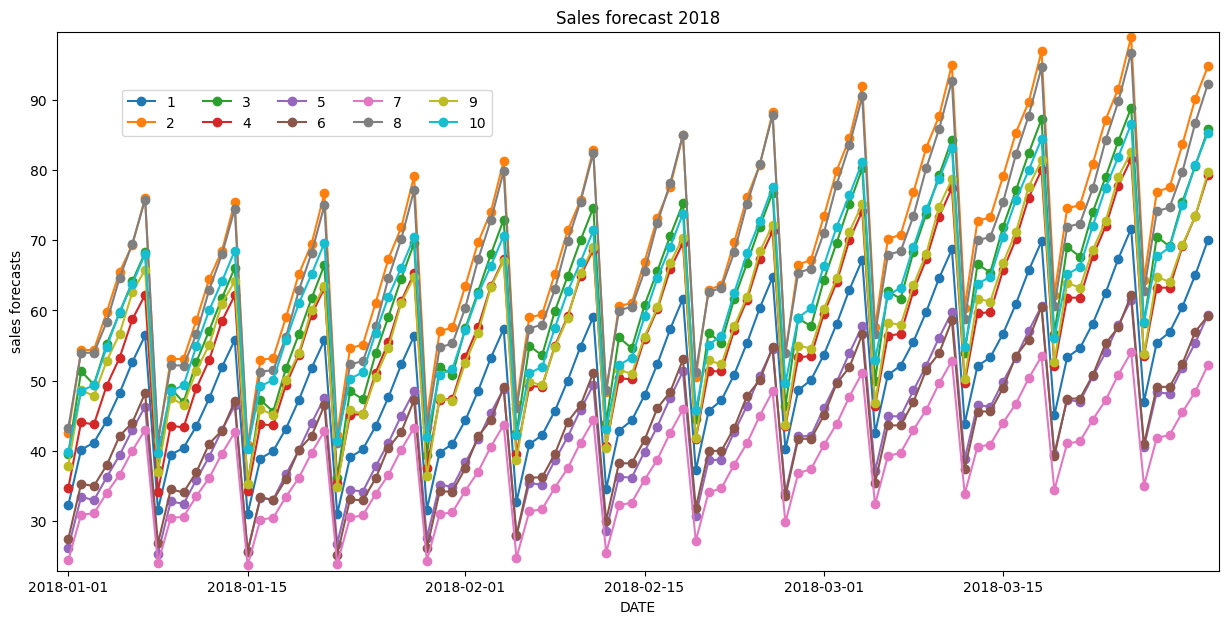

In [201]:
#sales forecast 2018
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_forecast_2018.copy() #stop cause error when editing on same df
df_plotting.set_index('date', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index,
                    columns=df_plotting.store, sort=False)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure(figsize=(15,7)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("DATE")
ax.set_ylabel('sales forecasts')

ax.set_title('Sales forecast 2018')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.05, .85), ncol = 5) #add the column names as legend.
ax.margins(x=0.01, y=0.01)

plt.show()

We can do similarly to item 2

In [175]:
#collect data to convert to dataframe
query_forecast_2018 ='''\
SELECT date, store, sales_predicted
FROM forecasts 
WHERE YEAR(date) == 2018 and item == 2;'''

#convert to dataframe for plotting
df_forecast_2018 = spark.sql(query_forecast_2018).toPandas()

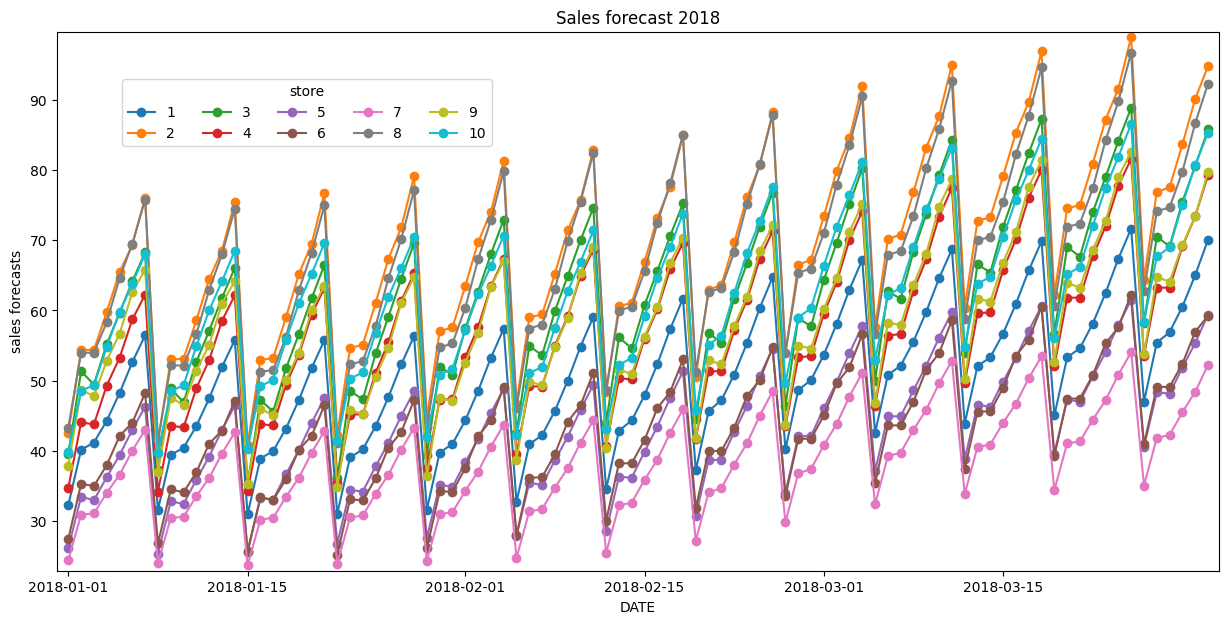

In [179]:
#sales forecast 2018
#libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

df_plotting = df_forecast_2018.copy() #stop cause error when editing on same df
df_plotting.set_index('date', inplace=True)

pt_df_plotting = pd.pivot_table(df_plotting,
                    index=df_plotting.index,
                    columns=df_plotting.store, sort=False)
pt_df_plotting.columns = pt_df_plotting.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.

ax = plt.figure(figsize=(15,7)).add_subplot()
ax.plot(pt_df_plotting, marker='o')
ax.set_xlabel("DATE")
ax.set_ylabel('sales forecasts')

ax.set_title('Sales forecast 2018')
#ax.xaxis("New")
ax.legend(pt_df_plotting.columns.tolist(), loc='center left', bbox_to_anchor=(0.05, .85), ncol = 5, title='store') #add the column names as legend.
ax.margins(x=0.01, y=0.01)

plt.show()

#### Evaluation metrics

Use the UDF technique to generate evaluation metrics for each store-item forecast

In [189]:
# schema of expected result set
eval_schema = StructType([
    StructField('training_date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('mae', FloatType()),
    StructField('mse', FloatType()),
    StructField('rmse', FloatType())
])

#define udf to calculate metrics
@pandas_udf(eval_schema, PandasUDFType.GROUPED_MAP)
def evaluate_forecast(evaluation_pd):
    
    #get store and item
    training_date = evaluation_pd['training_date'].iloc[0]
    store = evaluation_pd['store'].iloc[0]
    item = evaluation_pd['item'].iloc[0]
    
    #calculate metrics
    mae = mean_absolute_error(evaluation_pd['y'], evaluation_pd['yhat'])
    mse = mean_squared_error(evaluation_pd['y'], evaluation_pd['yhat'])
    rmse = sqrt(mse)
    
    #assemble result set
    results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae],
              'mse':[mse], 'rmse':[rmse]}
    
    return pd.DataFrame.from_dict(results)

#calculate metrics
# limit evaluation to periods where we have historical data
results = (
    spark
    .table('new_forecasts').filter('ds < \'2018-01-01\'')
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .apply(evaluate_forecast)
)

results.createOrReplaceTempView('new_forecast_evals')

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


See how reliability of our forecast

In [192]:
%%sparksql
SELECT store, AVG(mae), AVG(mse), AVG(rmse)
FROM new_forecast_evals
GROUP BY store
ORDER BY store DESC;

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -45.4184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3296.19    0.00303482       93.5741           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be remo

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -23.978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3725.41   9.10522e-05       82.5974      0.2193           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3725.43   1.44737e-05       66.9976     2.5e-07       0.001      225  LS failed, Hessian reset 
     199       3725.44   5.38631e-06       71.7403      0.2437           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3725.44   9.03753e-07       78.2616      0.0761           1      351   
Optimization terminated normally: 
  Convergenc

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -31.7024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     278       3832.16   0.000388458        111.81   4.023e-06       0.001      512  LS failed, Hessian reset 
Initial log joint probability = -18.1595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3832.2   2.60713e-05       90.9295       0.652       0.652      538   
    It

     138        3488.1   1.04431e-05       87.7899   1.383e-07       0.001      248  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     156        3488.1   1.67133e-07       59.1606      0.2322           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -27.6182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      88       3953.88   0.000104

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -24.2699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -46.0098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

      91       4263.65    0.00014074       96.0213   6.103e-07       0.001      153  LS failed, Hessian reset 
      99        4049.1   0.000121937       80.7398      0.6198      0.6198      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4263.7   3.13766e-05       91.1568       0.284           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       4049.11   1.55023e-05       59.4465   1.912e-07       0.001      199  LS failed, Hessian reset 
     149       4263.71   1.59633e-07       78.5409      0.3775           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     140       4049.11   3.22365e-07       62.0296           1           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/li

     129       3469.28     0.0011432       266.751   1.078e-05       0.001      192  LS failed, Hessian reset 
     180       4206.95   2.94723e-06       84.2619   3.957e-08       0.001      278  LS failed, Hessian reset 
     187       4206.95   1.01426e-07       71.8266      0.2019      0.2019      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3469.57   0.000128443       87.2992      0.8069      0.8069      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

     157        4281.4   0.000345326       79.6736   4.885e-06       0.001      310  LS failed, Hessian reset 
     199       4281.43   2.15414e-05       76.0864      0.5349      0.5349      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -29.8091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       4281.44   1.88741e-07       56.3772     3.1e-09       0.001      505  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: Future

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -45.4157
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -31.7903
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3562.57   0.000125942        66.312      0.6732      0.6732      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       3562.62   

     175       3606.76   0.000209378       115.595   1.953e-06       0.001      284  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -27.6622
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3606.78   3.81458e-06       91.1662       0.261           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3606.78   3.75906e-06       82.7796   4.266e-08       0.001      373  LS failed, Hessian reset 
     229       3606.78   1.12168e-07       87.9823      0.2632      0.7234      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/min

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -41.6087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4156.2    0.00304546       126.607      0.6903      0.6903      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3583.29    0.00103947       97.5327      0.4234      0.5717      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       4156.47   0.000103494       102.695   9.315e-07       0.001      256  LS failed, Hessian reset 
     100        3583.3   0.000434807       104.559   4.458e-06       0.001      173  LS failed, Hessian reset 
     152       3583.34

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -63.7594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3315.26   7.06544e-07         56.86      0.2516      0.2516      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       3315.26   1.23822e-05       83.5784   1.613e-07       0.001      186  LS failed, Hessian reset 
     137       3315.27   3.63415e-07       76.4002           1           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

     230       3651.77   1.35272e-07       67.3765      0.8051      0.8051      330   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log 

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -30.2772
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3424.94   0.000191728       89.8026      0.1428      0.8348      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3424.94    7.3195e-05       78.1203   8.252e-07       0.001      187  LS failed, Hessian reset 
     158       3424.97   0.000220318       99.3137   1.874e-06       0.001      289  LS failed, Hessian reset 
     199          3425   0.000145408       69.8059      0.9848      0.9848      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       3425.05

     199       3994.03   4.86581e-06       68.4685      0.8204      0.8204      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       3994.03   1.77305e-07       72.3145      0.5269      0.5269      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWar

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     185        3496.2   1.46521e-07       83.2959      0.3437           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/minicon

     199       3433.99   5.80903e-05       81.2985           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       3433.99   2.13349e-05       71.7785   3.135e-07       0.001      369  LS failed, Hessian reset 
      99        4252.2    0.00121946       89.6929           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247          3434   2.73695e-07       64.9236      0.4922           1      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/for

     170       4098.14   2.38853e-07       70.2193       0.747       0.747      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      79       3738.62   5.12774e-05       70.2419   1.131e-06       0.001      146  LS failed, Hessian reset 
      99       3738.64   0.000231335       67.5877      0.3816           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

      99       3970.77    0.00425609       145.915      0.4985           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       3971.56   0.000103217        86.049   1.361e-06       0.001      305  LS failed, Hessian reset 
     199       3971.57   2.56894e-05       48.5584      0.5587           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3971.57   5.21227e-06       80.5608   7.469e-08       0.001      400  LS failed, Hessian reset 
     258       3971.57   2.70917e-07       51.9339      0.6103           1      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -19.4902                        (146 + 8) / 700]
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -25.0383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       3417.27   0.000149184       94.1816   1.631e-06       0.001      132  LS failed, Hessian reset 
      99        3417.3   1.89893e-06        80.064   

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -30.3879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.6291
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3483.92   3.89907e-07        64.461           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       3483.92   

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -20.8748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4097.79   0.000137666       93.6705           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        4097.8   6.26724e-05       82.7845   7.299e-07       0.001      202  LS failed, Hessian reset 
     148       4097.81   1.19862e-07       63.4

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -56.922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3882.22   6.02492e-05       55.9738      0.5161      0.5161      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       3882.58   0.000385726       192.278   3.441e-06       0.001      254  LS failed, Hessian reset 
     199       3882.63   3.29255e-05       82.78

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -27.2115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -36.5766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4543.9   0.000239699       67.1047           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4026.36   

      99       3934.93   0.000187116       66.7437      0.3815           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       4317.17   0.000354611       59.9113           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       3936.24   0.000177219       98.7133   9.457e-07       0.001      331  LS failed, Hessian reset 
     199       3936.32   2.20649e-06       86.4466      0.1619           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       4317.75    0.00119881        97.492   1.435e-05       0.001      286  LS

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -28.184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       3890.55    0.00024843       155.577   2.167e-06       0.001      153  LS failed, Hessian reset 
      99       3890.59   0.000134707       73.6824      0.4407           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        3890.6   2.27017e-07       65.31

     155       3363.55   2.97076e-05        79.893    3.63e-07       0.001      242  LS failed, Hessian reset 
     199       3363.56   3.80304e-07       72.4958      0.8028      0.2873      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3363.56   4.06945e-06        73.686   6.157e-08       0.001      379  LS failed, Hessian reset 
     227       3363.57   1.86788e-06       71.6514   2.592e-08       0.001      430  LS failed, Hessian reset 
     239       3363.57   4.93614e-08       75.2773      0.1806           1      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthous

     206       3552.45   4.57126e-05       98.9097   4.776e-07       0.001      345  LS failed, Hessian reset 
     230       3552.45   6.02367e-08       70.8197      0.1933      0.1933      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

      84       4129.72    0.00037225        202.36   4.263e-06       0.001      155  LS failed, Hessian reset 
      99       4129.83   0.000109529       90.6944           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3966.61   3.24885e-06       71.3644      0.7267      0.7267      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       4129.91   2.66958e-05       74.6121   3.943e-07       0.001      304  LS failed, Hessian reset 
     306       3966.61   2.01545e-05       87.5019   2.729e-07       0.001      510  LS failed, Hessian reset 
     193       4129.92   5.04652e-07       74.4106      0.2495           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.ap

      88        3530.5   0.000337573       104.279   3.595e-06       0.001      142  LS failed, Hessian reset 
     199       3427.43   3.77087e-07       84.0563           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       3427.43   1.27104e-07       82.0437      0.3739           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       3530.52   1.66029e-05       79.4079      0.2521           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/for

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -43.329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3873.99   1.29695e-06       66.8335       1.621     0.01621      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3873.99   1.84826e-07       61.9415      0.5722      0.5722      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compone

     242       4162.18   1.15609e-05       103.253    1.54e-07       0.001      412  LS failed, Hessian reset 
     257       4162.18   3.82896e-07       63.2285      0.6603      0.2166      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     119          4162    0.00012805       66.5077   2.002e-06       0.001      196  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     179       4162.06   0.000208414       71.0891   2.

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -39.2096
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4046.99    0.00103814       130.785           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       4047.07   2.33384e-07       86.3261      0.3609           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

      85       4218.29   0.000372678       158.381    4.09e-06       0.001      163  LS failed, Hessian reset 
      99       4218.37   0.000566618        61.492           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -20.1013
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       4218.48   2.61696e-05       69.5101   3.682e-07       0.001      319  LS failed, Hessian reset 
     187       4218.48   3.50419e-07       53.8343           1           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/min

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -25.6411
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       3784.22    2.9288e-05       70.4063   3.435e-07       0.001      161  LS failed, Hessian reset 
      99       3784.23    8.3118e-06        74.841      0.1912      0.8048      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3784.23   5.16044e-08       67.3989     0.08185           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

     224        3458.8   2.23375e-05       76.0205   2.744e-07       0.001      329  LS failed, Hessian reset 
     244       3458.81   3.10343e-08       68.3166    0.008269           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

      83       4037.16   0.000119074       82.1872    8.82e-07       0.001      140  LS failed, Hessian reset 
      99       3345.45   3.97651e-05       67.9812       2.153      0.5259      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4037.5    0.00059852        71.764      0.3149           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3345.46   7.87114e-05       85.5908   1.023e-06       0.001      216  LS failed, Hessian reset 
     170       4037.62   0.000144776        135.11   1.411e-06       0.001      292  LS failed, Hessian reset 
     176       3345.46   2.16189e-07       64.2346      0.2844           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.ap

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -25.2107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4004.11   0.000433652       193.466   4.756e-06       0.001      167  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4004.22    6.9663e-05       74.1545           1           1      284   
    Iter      log prob        ||dx||      ||gra

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.5519
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       3785.57   0.000154703       93.9675   1.721e-06       0.001      139  LS failed, Hessian reset 
      99       3785.58   1.20823e-07       71.4805     0.01874       0.215      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       3785.59   6.19917e-06       75.6588   7.808e-08       0.001      255  LS failed, Hessian reset 
     157       3785.59   1.06566e-07       71.5442     0.06094           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/min

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -24.958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3602.49   1.11316e-06       85.1128      0.6367      0.6367      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3602.49   1.84808e-07       68.5939           1           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compone

     185       3581.75   2.48562e-07        64.563           1           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       4162.56   0.000159795        69.626           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWar

      95       4201.24   0.000125801       82.6907   6.625e-07       0.001      205  LS failed, Hessian reset 
      99       4201.36   0.000344395       51.5109      0.5981      0.5981      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       3280.69   0.000463276       139.542   4.375e-06       0.001      134  LS failed, Hessian reset 
      99       3280.74   9.82087e-06       74.1955      0.5761      0.5761      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182        4201.9   0.000182902       146.868   2.389e-06       0.001      366  LS failed, Hessian reset 
     199       4201.99   0.000203617       85.5921      0.7962      0.7962      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       3280.78   7.80734e-05       77.1344   8.028e-07       0.001      265  LS failed, Hessian reset 
     184       3280

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -36.5065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       3398.28   0.000395208       150.329    3.21e-06       0.001      140  LS failed, Hessian reset 
      99       3398.54    0.00105342       105.734           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       3399.47    0.00165122       377.816   1.214e-05       0.001      258  LS failed, Hessian reset 
     199       3399.88   1.31475e-05       74.5964           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3399.93

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -36.6434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3404.21   0.000535596       80.4909   6.196e-06       0.001      155  LS failed, Hessian reset 
      99       3404.24   8.84049e-06       75.6113      0.3305      0.3305      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3404.27   1.99247e-05       79.0

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -35.7543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4281.06   3.41953e-05       71.2043           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       4281.19   0.000225843       161.754   2.331e-06       0.001      203  LS failed, Hessian reset 
     199       4281.28   3.90199e-05       65.6756      0.3623      0.3623      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       4281.42   4.27866e-06       65.6891   5.969e-08       0.001      453  LS failed, Hessian reset 
     299       4281.42

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -33.3818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3959.24   0.000109457       80.4831           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3959.34   2.33961e-05       68.8169   2.672e-07       0.001      216  LS failed, Hessian reset 
     158       3959.35    3.8402e-07       70.3689      0.2635           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -33.3575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4208.13   0.000489653       112.352      0.1015      0.7522      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       4208.14   0.000235786       108.237   2.727e-06       0.001      188  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.0597
    It

     131       3173.77   6.13974e-06        81.615   6.299e-08       0.001      244  LS failed, Hessian reset 
     144       3173.78   9.81734e-08       77.3271      0.2497           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

     218       4174.61     0.0001613       143.039   1.447e-06       0.001      392  LS failed, Hessian reset 
     299       4174.72   3.18855e-05       67.5242      0.5301           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       4174.73   1.34335e-06       69.5311   1.533e-08       0.001      589  LS failed, Hessian reset 
     339       4174.73   4.23187e-07       50.1555      0.3517      0.7957      593   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -30.6045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3645.82   2.20792e-06       70.0969           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3645.82   5.21765e-07       61.5442      0.8383      0.8383      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -31.6705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/fo

     191        3142.7   7.37366e-05       62.2542    1.05e-06       0.001      315  LS failed, Hessian reset 
     199        3142.7   2.64692e-06       56.6892           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213        3142.7   9.00004e-08       56.0239      0.3834     0.03834      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      72       3978.71   0.000269377       160.531   3.576e-06       0.001      132  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

     199       4531.86   5.56008e-06       59.4345      0.3013      0.3013      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -30.1009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4531.86   2.21204e-05       71.9474   2.513e-07       0.001      402  LS failed, Hessian reset 
     247       4531.86   1.86661e-07        67.316      0.3596           1      445   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       3998.85    0.00025685       150.901   2.912e-06       0.001      145  LS failed, Hessian reset 
      99       3998.88   4.51882e-06       78.0709      0.3464      0.3464      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3998.89   5.27942e-05       59.6851   4.484e-07       0.001      238  LS failed, Hessian reset 
     185       3998.94   0.000243418       103.844   2.962e-06       0.001      378  LS failed, Hessian reset 
     199       3998.97   1.21841e-05       64.8378           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       3998.98   2.11506e-07       70.1618      0.7657      0.7657      450   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lig

     165       3707.57   1.12161e-07       72.5808      0.5761      0.5761      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     278       4113.51   1.83252e-07       65.4399      0.2217           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:

      99       3381.21   3.06381e-06        60.514      0.4384           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        3381.3   0.000222793       92.3579   3.645e-06       0.001      201  LS failed, Hessian reset 
     180       3381.32   6.36519e-07       84.3211      0.4018           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -24.5351
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3518.49   0.000247507       118.046   2.051e-06       0.001      171  LS failed, Hessian reset 
      99       3518.73    0.00221572       109.887           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       3519.18    0.00105892       136.949   1.175e-05       0.001      261  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -45.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -49.1131
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3989.59   0.000481382       77.2306    5.54e-06       0.001      160  LS failed, Hessian reset 
      99       3989.61   0.000203934       82.4308      0.9438      0.9438      164   
    Iter

      99       4206.89   5.54609e-05        79.341      0.6592      0.6592      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       4206.94   0.000173376        116.18   1.911e-06       0.001      198  LS failed, Hessian reset 
     199       4206.95   9.40064e-06       91.2278           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211          4207   0.000132387       117.067   1.319e-06       0.001      352  LS failed, Hessian reset 
     240       4207.03   1.19425e-07       63.2391      0.2166       0.541      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com

     150       4410.59   2.67442e-07       59.3464      0.2321           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       4155.57   0.000396204       59.7421           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWar

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -36.8388
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4272.04   0.000978015       295.313      0.7163      0.7163      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       4273.04    0.00026372       92.1309   3.287e-06       0.001      269  LS failed, Hessian reset 
     199       4273.05   3.10365e-06       63.4234      0.5978      0.5978      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       4273.05   1.56935e-07        74.759      0.1957      0.4122      308   
Optimization terminated normally: 
  Convergen

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -21.3453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -19.6557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       4312.39   0.000518352       142.646   7.066e-06       0.001      126  LS failed, Hessian reset 
      99       4312.46    3.7398e-05       65.5001           1           1      156   
    It

      92       3893.41    0.00150718       225.598   1.452e-05       0.001      166  LS failed, Hessian reset 
      99       3859.44    0.00709778       147.219           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3893.47   6.06452e-05       89.0089       0.132           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3859.46   0.000164098       109.486   1.368e-06       0.001      187  LS failed, Hessian reset 
     147       3859.51   1.94871e-07       73.9324      0.5611      0.5611      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     168       3893.48   5.84653e-08       83.7987       0.254           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/li

      64       3327.91     0.0011164       104.494   1.408e-05       0.001      128  LS failed, Hessian reset 
     131       4123.34   0.000143048       83.8286    1.83e-06       0.001      250  LS failed, Hessian reset 
      91       3327.96   3.36174e-05       70.9838   4.715e-07       0.001      191  LS failed, Hessian reset 
      99       3327.96   5.31475e-06       60.4801           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       3327.96   6.31619e-08       72.5456      0.1399      0.5479      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     168       4123.35    1.15

     168       4407.71    0.00022096       148.317   2.918e-06       0.001      341  LS failed, Hessian reset 
     199       4407.84   6.60453e-06       68.6966      0.4018           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       4407.86   4.17727e-08       63.4526     0.07823     0.07823      463   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -34.8558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       3821.72   0.000225586       88.4715   2.754e-06       0.001      127  LS failed, Hessian reset 
      99       3821.74   5.71274e-07       70.3802      0.9285      0.9285      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3821.74   1.38912e-07        68.887      0.7502      0.7502      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

      93       3505.54   9.27091e-06        56.264   1.476e-07       0.001      176  LS failed, Hessian reset 
     239       4059.39   0.000335291       219.105   2.705e-06       0.001      362  LS failed, Hessian reset 
      99       3505.54   4.28421e-07       50.8127       0.133      0.9646      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       3505.54   9.03048e-08       58.8447       0.108      0.3551      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

     160       4095.86   0.000472117       76.8025   4.769e-06       0.001      245  LS failed, Hessian reset 
     194       4095.88   1.07955e-05       82.8882   1.398e-07       0.001      321  LS failed, Hessian reset 
     199       4095.88   6.40066e-07       71.0212      0.2408           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       4095.88   3.33059e-08       63.8418     0.05725           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -37.8188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3483.94   6.03485e-06       71.7781           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       3483.94   2.07483e-07       77.2463           1           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -25.5364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       4193.92   0.000136182       123.024   9.934e-07       0.001      166  LS failed, Hessian reset 
      99       4193.93   8.15207e-05       112.608           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       4194.01   2.78354e-07        86.

     103       3858.04   6.81887e-06       88.1548   7.754e-08       0.001      165  LS failed, Hessian reset 
     123       3858.04   1.49436e-07       61.1548      0.3288           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     299       4133.11    3.0416e-05       77.5422      0.1551      0.1551      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

      99        3831.5   3.33397e-06       74.8158           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107        3831.5   7.44892e-06        77.278    9.07e-08       0.001      186  LS failed, Hessian reset 
     122        3831.5   2.56291e-07       68.6135           1           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

     214        3592.1   1.87137e-07       79.7951           1           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log 

     132       3956.56   0.000144852       77.3072   1.795e-06       0.001      249  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     180       3956.57   2.73585e-05         81.14    2.53e-07       0.001      343  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3956.57   4.40916e-07       83.1961        1.48      0.3475      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3956.57   1.38245e-07       74.7101      0.5059      0

     211       3828.78   9.77952e-08        69.208      0.1355      0.8594      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     182       3247.25   0.000434978       88.0079   4.666e-06       0.001      317  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3247.28   5.98539e-06       74.6068           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -27.3631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -47.9003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3845.83   8.58466e-05       68.7155           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3473.02   

     172       3579.12   0.000362684       83.3932   4.888e-06       0.001      273  LS failed, Hessian reset 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
     199       3579.15   4.16548e-05       69.4825           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -81.8318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       3579.15   9.46159e-08       67.1744      0.2718      0.2718      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

     248       4109.15   0.000297282       189.331   4.042e-06       0.001      410  LS failed, Hessian reset 
     299       4109.24   5.98123e-05       65.7988           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       4109.26   9.74119e-05       81.5802   1.622e-06       0.001      539  LS failed, Hessian reset 
     367       4109.27   2.69619e-07       71.4567           1           1      595   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated

     153       4200.45   3.10551e-05       78.1453     3.2e-07       0.001      298  LS failed, Hessian reset 
     181       4200.45   1.19145e-07       79.7118      0.2055           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -33.5221
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -31.5903
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3401.54   0.000248929       81.1942           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3401.62   

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -38.793
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       4022.36   0.000232182       154.433   2.859e-06       0.001      148  LS failed, Hessian reset 
      99       4022.38   1.35168e-05       62.2856           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       4022.38    2.0994e-07       73.36

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -41.7037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3518.13   0.000536975       63.7372           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3518.18   0.000454811        65.514   5.881e-06       0.001      170  LS failed, Hessian reset 
     157        3518.2   7.28815e-08       62.1703       0.201           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.appen

     358       4303.15   1.80276e-06       75.0123   3.015e-08       0.001      635  LS failed, Hessian reset 
     373       4303.15   4.26687e-07       68.4787      0.2773           1      655   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
      99       3567.42   0.000132779       82.1976      0.4045      0.4045      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.appe

/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/envs/lighthouse/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Initial log joint probability = -26.9763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3881.21    0.00131742       124.675           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       3881.31   1.34167e-07       83.3659      0.3079      0.9659      204   
Optimization terminated normally: 
  Convergence detected: relative gra

store,avg(mae),avg(mse),avg(rmse)
10,6.205101709365845,64.6818741607666,7.829530048370361
9,5.996161761283875,60.39468784332276,7.5618703651428225
8,6.509050059318542,71.02698871612549,8.208288679122925
7,4.787070889472961,38.40148170471191,6.043139395713806
6,5.015025601387024,42.24545804977417,6.333742618560791
5,5.03526533126831,42.58844564437866,6.3595049810409545
4,5.986098456382751,60.235491638183596,7.55930025100708
3,6.255470924377441,65.63998706817627,7.884935073852539
2,6.686703763008118,75.2316349029541,8.438625030517578
1,5.532019557952881,51.286226425170895,6.970857286453247
